In [4]:
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Text preprocessing and vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Machine learning models and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Graph construction and GNN
import networkx as nx
import torch


In [5]:
# Load the datasets
true_df = pd.read_csv('/content/True.csv')
fake_df = pd.read_csv('/content/Fake.csv')

# Add labels: 1 for true, 0 for fake
true_df['label'] = 1
fake_df['label'] = 0

# Combine into one DataFrame
df = pd.concat([true_df, fake_df], ignore_index=True)

# Shuffle the combined dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Preview the data
print("Combined dataset shape:", df.shape)
print(df[['title', 'subject', 'date', 'label']].head())


Combined dataset shape: (44898, 5)
                                               title       subject  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...          News   
1   Failed GOP Candidates Remembered In Hilarious...          News   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...          News   
3  California AG pledges to defend birth control ...  politicsNews   
4  AZ RANCHERS Living On US-Mexico Border Destroy...      politics   

               date  label  
0     July 21, 2017      0  
1       May 7, 2016      0  
2  December 3, 2016      0  
3  October 6, 2017       1  
4      Apr 25, 2017      0  


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Combine title and text for content representation
df['content'] = df['title'] + " " + df['text']

# Basic text preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['clean_content'] = df['content'].apply(clean_text)

# Apply TF-IDF vectorization (limit to top 10,000 features for memory efficiency)
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['clean_content'])

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)


TF-IDF matrix shape: (44898, 10000)


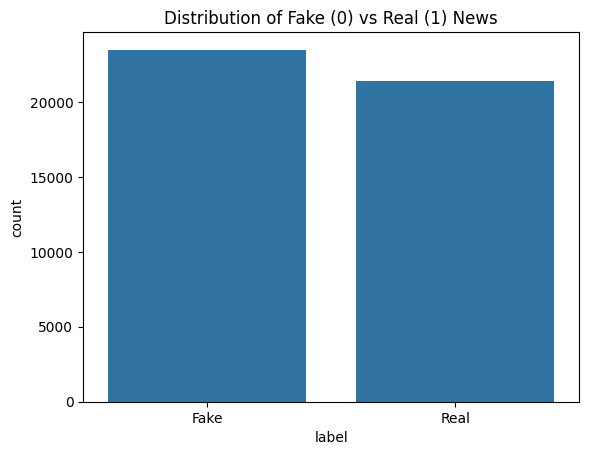

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Class distribution
sns.countplot(x='label', data=df)
plt.title("Distribution of Fake (0) vs Real (1) News")
plt.xticks([0,1], ['Fake', 'Real'])
plt.show()


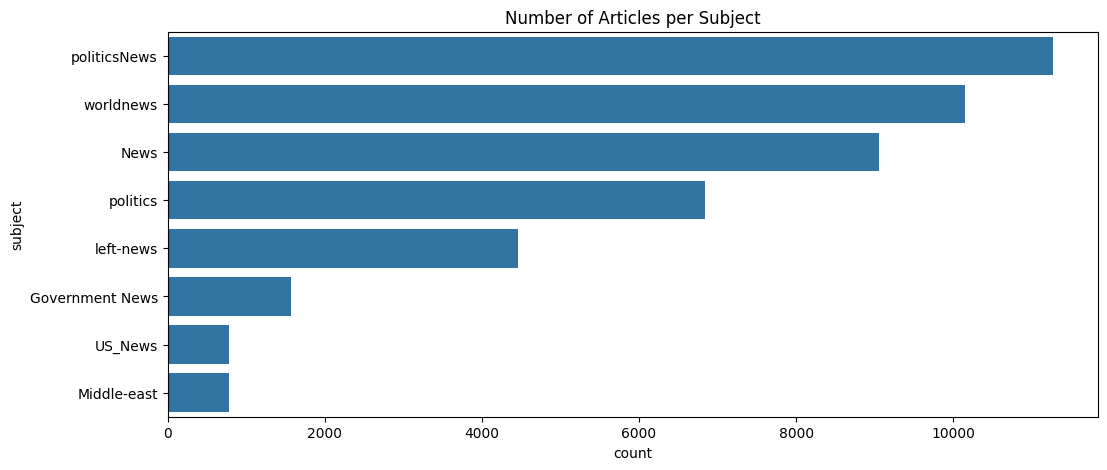

In [8]:

# 2. Subject-wise article count
plt.figure(figsize=(12,5))
sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index)
plt.title("Number of Articles per Subject")
plt.show()



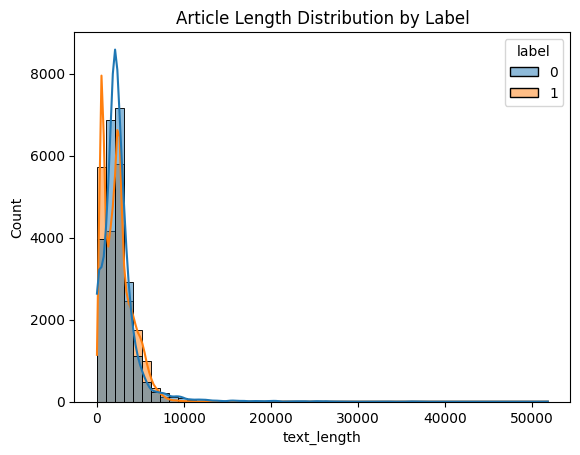

In [9]:
# 3. Article length distribution (by characters)
df['text_length'] = df['text'].apply(len)
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title("Article Length Distribution by Label")
plt.show()

In [10]:


# 4. Average length of fake vs real articles
avg_len = df.groupby('label')['text_length'].mean()
print("Average text length:\n", avg_len)




Average text length:
 label
0    2547.396235
1    2383.278517
Name: text_length, dtype: float64


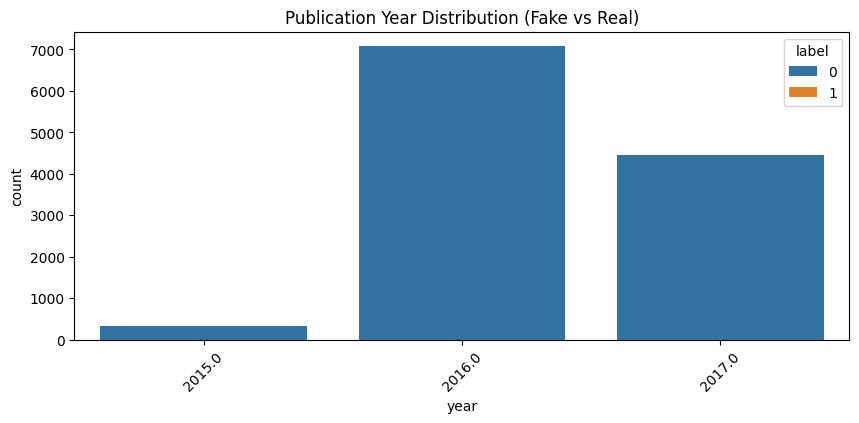

In [11]:
# 5. Publication timeline (articles per year)
df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='year', hue='label')
plt.title("Publication Year Distribution (Fake vs Real)")
plt.xticks(rotation=45)
plt.show()


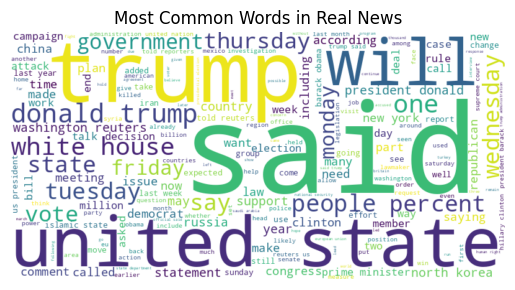

In [12]:

# 7. Most frequent words in real news
real_words = " ".join(df[df['label'] == 1]['clean_content'].tolist())
wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_words)
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Real News")
plt.show()


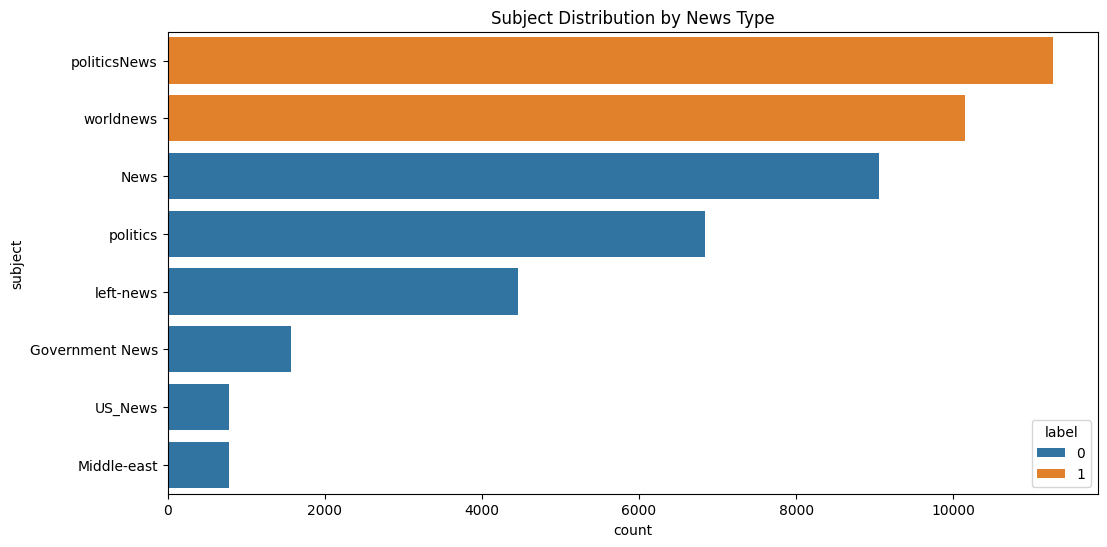

In [13]:

# 8. Subject distribution by label
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='subject', hue='label', order=df['subject'].value_counts().index)
plt.title("Subject Distribution by News Type")
plt.show()


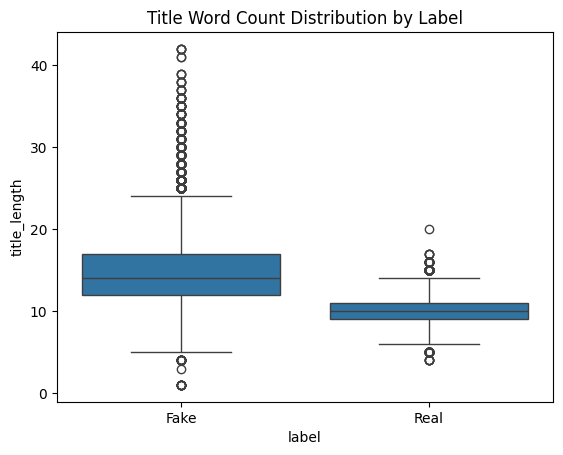

In [14]:

# 9. Title length vs label
df['title_length'] = df['title'].apply(lambda x: len(x.split()))
sns.boxplot(data=df, x='label', y='title_length')
plt.title("Title Word Count Distribution by Label")
plt.xticks([0,1], ['Fake', 'Real'])
plt.show()



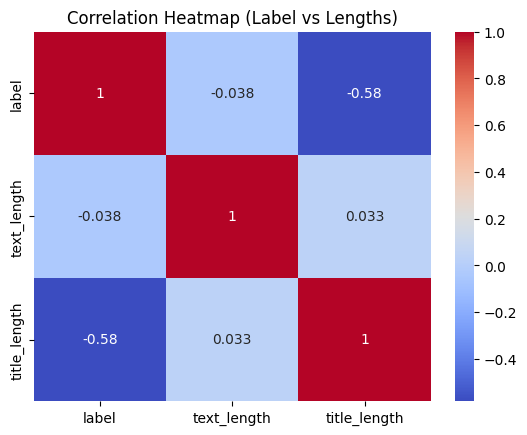

In [15]:
# 10. Correlation heatmap (length-based)
corr_df = df[['label', 'text_length', 'title_length']].corr()
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Label vs Lengths)")
plt.show()

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import re

# Re-run sampling from cleaned DataFrame
sample_size = 5000
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Clean again if needed
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_sample['clean_content'] = df_sample['title'] + " " + df_sample['text']
df_sample['clean_content'] = df_sample['clean_content'].apply(clean_text)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_sample['clean_content'])

# Build edges using NearestNeighbors (fast + memory-safe)
nn = NearestNeighbors(n_neighbors=6, metric='cosine')  # 5 neighbors + self
nn.fit(tfidf_matrix)

distances, indices = nn.kneighbors(tfidf_matrix)

edges = []
for i in range(indices.shape[0]):
    for j in range(1, indices.shape[1]):  # skip self at index 0
        if 1 - distances[i][j] > 0.7:
            edges.append((i, indices[i][j]))

print(f" Total edges constructed: {len(edges)}")


 Total edges constructed: 589


In [19]:

!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 6.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.9 MB/s eta 0:00:00


In [20]:
import torch
from torch_geometric.data import Data

# Step 1: Node features from TF-IDF (convert to dense tensor)
x = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float)

# Step 2: Convert edges to tensor format [2, num_edges]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Step 3: Labels (convert to tensor)
y = torch.tensor(df_sample['label'].values, dtype=torch.long)

# Step 4: Create graph data object
data = Data(x=x, edge_index=edge_index, y=y)

print(data)


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Data(x=[5000, 5000], edge_index=[2, 589], y=[5000])


In [21]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Module, Linear

class GCN(Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [24]:
import torch

# Set random seed for reproducibility
torch.manual_seed(42)

# Total number of nodes
num_nodes = data.num_nodes

# Create boolean masks for train/val/test
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.6 * num_nodes)]
val_idx = perm[int(0.6 * num_nodes):int(0.8 * num_nodes)]
test_idx = perm[int(0.8 * num_nodes):]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Attach masks to data
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(in_channels=data.num_node_features, hidden_channels=64, out_channels=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation
def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[mask] == data.y[mask]).sum().item()
    acc = correct / mask.sum().item()
    return acc

# Run training
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        val_acc = test(data.val_mask)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

# Final test accuracy
test_acc = test(data.test_mask)
print(f" Test Accuracy: {test_acc:.4f}")


Epoch 020, Loss: 0.0359, Val Acc: 0.9760
Epoch 040, Loss: 0.0273, Val Acc: 0.9790
Epoch 060, Loss: 0.0204, Val Acc: 0.9820
Epoch 080, Loss: 0.0168, Val Acc: 0.9840
Epoch 100, Loss: 0.0146, Val Acc: 0.9840
Epoch 120, Loss: 0.0132, Val Acc: 0.9840
Epoch 140, Loss: 0.0123, Val Acc: 0.9850
Epoch 160, Loss: 0.0113, Val Acc: 0.9840
Epoch 180, Loss: 0.0107, Val Acc: 0.9840
Epoch 200, Loss: 0.0103, Val Acc: 0.9850
 Test Accuracy: 0.9780


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use tfidf_matrix and df_sample
X = tfidf_matrix  # sparse TF-IDF matrix
y = df_sample['label'].values

# Train/val/test split (same proportions as GCN)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [27]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Evaluation function
def evaluate(name, y_true, y_pred):
    print(f"\n {name} Performance:")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")

# Run evaluation
evaluate("Logistic Regression", y_test, lr_preds)
evaluate("Random Forest", y_test, rf_preds)



 Logistic Regression Performance:
Accuracy : 0.9710
Precision: 0.9665
Recall   : 0.9726
F1 Score : 0.9696

 Random Forest Performance:
Accuracy : 0.9880
Precision: 0.9874
Recall   : 0.9874
F1 Score : 0.9874


Prediction Confidence & Comparison with Baselines

In [28]:
# GCN final predictions & probabilities
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    probs = F.softmax(out, dim=1)
    gcn_preds = out.argmax(dim=1).cpu().numpy()
    gcn_probs = probs.max(dim=1).values.cpu().numpy()


In [29]:
# For test indices only
test_indices = data.test_mask.cpu().numpy().nonzero()[0]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'index': test_indices,
    'true_label': data.y[test_indices].cpu().numpy(),
    'gcn_pred': gcn_preds[test_indices],
    'gcn_conf': gcn_probs[test_indices],
    'lr_pred': lr_preds,
    'rf_pred': rf_preds
})


In [33]:
# Where GCN is correct and RF is wrong
helped_cases = comparison_df[
    (comparison_df['gcn_pred'] == comparison_df['true_label']) &
    (comparison_df['rf_pred'] != comparison_df['true_label'])
]

print(f" GCN outperformed Random Forest on {len(helped_cases)} test cases.")
helped_cases.head()


 GCN outperformed Random Forest on 498 test cases.


,index,true_label,gcn_pred,gcn_conf,lr_pred,rf_pred
0,4,0,0,0.989771,1,1
1,5,0,0,0.625799,1,1
2,7,1,1,0.975727,0,0
6,22,0,0,0.999188,1,1
8,62,0,0,0.999579,1,1


In [35]:
def get_neighbors(node_id, edge_list):
    return [tgt for src, tgt in edges if src == node_id]

# Find one GCN-correct + RF-wrong case where neighbors exist
for _, row in helped_cases.iterrows():
    node_id = int(row['index']) # Convert to integer
    neighbors = get_neighbors(node_id, edges)
    if neighbors:
        print(f"\n Found contextual example: Node {node_id}")
        print(f"True label: {data.y[node_id].item()}, GCN prediction: {gcn_preds[node_id]}")
        print(f"Neighbors: {neighbors}")
        print("Neighbor labels:", data.y[neighbors].tolist())
        break


 Found contextual example: Node 22
True label: 0, GCN prediction: 0
Neighbors: [np.int64(1673)]
Neighbor labels: [0]
